In [1]:
# SVM,OLS, LDA, QDA, KNN, RF, NN
#
# Balanced Accuracy, Sensitivity, Specificity, F1 Score

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Helper Methods

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import seaborn as sns
sns.set()

def corrPlot(df):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    corr = df.corr()
    sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

def getReport(predictions, flag):
    if flag == 'test':
        theDf = target_test
    elif flag == 'val':
        theDf = target_val
    print("Balanced_Accuracy:", balanced_accuracy_score(theDf, predictions))
    print(classification_report(theDf, predictions))
    
def plotROC(model, flag):
    if flag == 'test':
        features = features_test
        target = target_test
    elif flag == 'val':
        features = features_val
        target = target_val
    probabilities = model.predict_proba(features)
    preds = probabilities[:,1]
    fpr, tpr, threshold = roc_curve(target, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.show()
    
    return plt

### Reading in Data

In [4]:
df = pd.read_csv('../ready4Learning2.csv', index_col = 0)
df.drop(df.tail(1).index,inplace=True)
df['Age@Scan'] = df['Age@Scan'].astype('float64')

print(df.ConsensusDiagnosis.value_counts())

print("\nDataType")
print(df['Age@Scan'].dtypes)

0    482
1    261
Name: ConsensusDiagnosis, dtype: int64

DataType
float64


### Downsampling (DISCONTINUED)

In [5]:
# from sklearn.utils import resample

# df_majority = df[df.ConsensusDiagnosis==0]
# df_minority = df[df.ConsensusDiagnosis==1]

# df_majority_downsampled = resample(df_majority, 
#                                    replace=False,
#                                    n_samples=261,
#                                    random_state=123)

# df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# print(df_downsampled.ConsensusDiagnosis.value_counts())

# target = df_downsampled.ConsensusDiagnosis
# features = df_downsampled.drop(['ConsensusDiagnosis', 'UNK', 'QMC', 'OTH', 'ScanDate'], axis = 1)


target = df.ConsensusDiagnosis
features = df.drop(['ConsensusDiagnosis', 'UNK', 'QMC', 'OTH', 'ScanDate'], axis = 1)

In [6]:
#corrPlot(df_downsampled.loc[:, 'Age@Scan':'REC_Thickness'])
#savefig('../images/fig1.png')

###  Standardizing Data

In [7]:
from sklearn.preprocessing import StandardScaler

features = StandardScaler().fit_transform(features)

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [8]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=0, )
features_train, features_val, target_train, target_val = train_test_split(features_train, target_train, test_size = 0.33, random_state = 0)

### Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


logit = LogisticRegression(solver='liblinear', max_iter=500)

# best_logit = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
#           intercept_scaling=0.0001, max_iter=500, multi_class='warn',
#           n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
#           tol=0.0001, verbose=0, warm_start=False)

penalties = ['l1', 'l2']
tols = [1e-2, 1e-3, 1e-4]
costs = [0.001, 0.01, 0.1, 1, 5, 10]
intercepts = [0.0001, 0.001, 0.1, 1]
fit_intercepts = [True, False]
classWeights = [None, 'balanced']

params_logit = {'C': costs, 'penalty': penalties, 'tol': tols, 
                'fit_intercept': fit_intercepts, 'class_weight': classWeights, 'intercept_scaling': intercepts}

gs_logit = GridSearchCV(logit, params_logit, cv=10)

gs_logit.fit(features_train, target_train)

best_logit = gs_logit.best_estimator_

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Balanced_Accuracy: 0.6691079812206573
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       150
           1       0.53      0.59      0.56        71

   micro avg       0.70      0.70      0.70       221
   macro avg       0.66      0.67      0.66       221
weighted avg       0.71      0.70      0.70       221



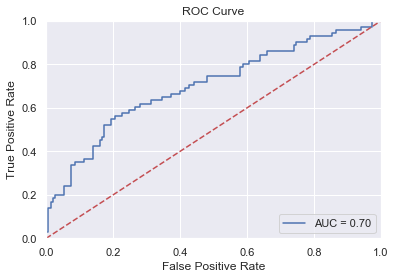

In [10]:
predictions = best_logit.predict(features_val)
getReport(predictions, 'val')
plotROC(best_logit, 'val')
savefig('../images/logit/reg_val.png')

Balanced_Accuracy: 0.7184650455927051
              precision    recall  f1-score   support

           0       0.78      0.83      0.80        47
           1       0.68      0.61      0.64        28

   micro avg       0.75      0.75      0.75        75
   macro avg       0.73      0.72      0.72        75
weighted avg       0.74      0.75      0.74        75



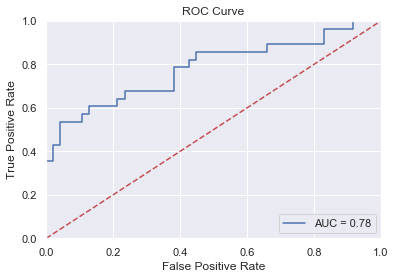

In [11]:
predictions = best_logit.predict(features_test)
getReport(predictions, 'test')
plotROC(best_logit, 'test').savefig('../images/logit/reg_test.png')

### LDA

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

solvers = ['lsqr']
shrinkages = [None, 'auto']
tols = [1e-3, 1e-4, 1e-5]
components = [0,1]

params_lda = {'solver': solvers,'shrinkage': shrinkages, 'tol': tols, 'n_components':components}

gs_lda = GridSearchCV(lda, params_lda, cv=10)
gs_lda.fit(features_train, target_train)

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'solver': ['lsqr'], 'shrinkage': [None, 'auto'], 'tol': [0.001, 0.0001, 1e-05], 'n_components': [0, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Balanced_Accuracy: 0.6820657276995306
              precision    recall  f1-score   support

           0       0.80      0.79      0.79       150
           1       0.56      0.58      0.57        71

   micro avg       0.72      0.72      0.72       221
   macro avg       0.68      0.68      0.68       221
weighted avg       0.72      0.72      0.72       221



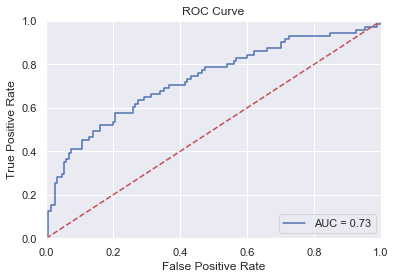

In [13]:
predictions = gs_lda.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_lda, 'val')
savefig('../images/lda/reg_val.png')

Balanced_Accuracy: 0.7218844984802432
              precision    recall  f1-score   support

           0       0.77      0.87      0.82        47
           1       0.73      0.57      0.64        28

   micro avg       0.76      0.76      0.76        75
   macro avg       0.75      0.72      0.73        75
weighted avg       0.76      0.76      0.75        75



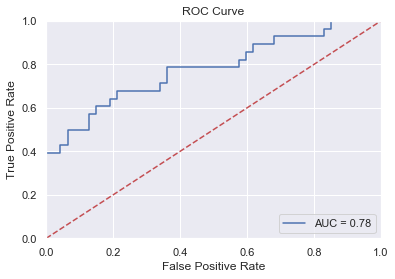

In [14]:
predictions = gs_lda.predict(features_test)
getReport(predictions, 'test')
plotROC(gs_lda, 'test')
savefig('../images/lda/reg_test.png')

### KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

neighbors = [1,3,5,7,9]
weights = ['uniform', 'distance']
algo = ['ball_tree', 'kd_tree', 'brute']

params_knn = {'n_neighbors': neighbors, 'weights': weights, 'algorithm': algo}
gs_knn = GridSearchCV(knn, params_knn, cv=10)

gs_knn.fit(features_train, target_train)

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Balanced_Accuracy: 0.7613615023474178
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       150
           1       0.68      0.68      0.68        71

   micro avg       0.79      0.79      0.79       221
   macro avg       0.76      0.76      0.76       221
weighted avg       0.79      0.79      0.79       221



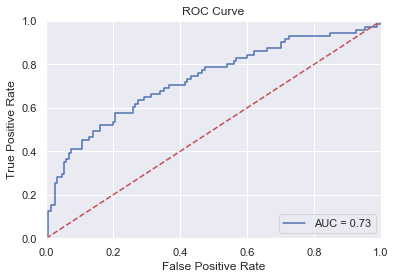

In [16]:
predictions = gs_knn.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_lda, 'val')
savefig('../images/knn/reg_val.png')

Balanced_Accuracy: 0.7040273556231003
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        47
           1       0.71      0.54      0.61        28

   micro avg       0.75      0.75      0.75        75
   macro avg       0.74      0.70      0.71        75
weighted avg       0.74      0.75      0.74        75



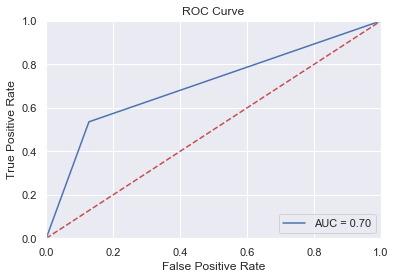

In [17]:
predictions = gs_knn.predict(features_test)
getReport(predictions, 'test')
plotROC(gs_knn, 'test')
savefig('../images/knn/reg_test.png')

### RF

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)

num_trees = [10, 15, 20, 25, 30, 40, 50]
criterion = ['gini']
max_depth = [10, 20, 30]
min_samples_leaf = [1,2,3,4]
min_samples_split = [1,2,3,4]

params_rf = {'n_estimators': num_trees, 'criterion': criterion, 'max_depth': max_depth}
gs_rf = GridSearchCV(rf, params_rf, cv=10)

gs_rf.fit(features_train, target_train)
gs_rf.best_estimator_

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Balanced_Accuracy: 0.737981220657277
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       150
           1       0.78      0.55      0.64        71

   micro avg       0.81      0.81      0.81       221
   macro avg       0.80      0.74      0.76       221
weighted avg       0.80      0.81      0.79       221



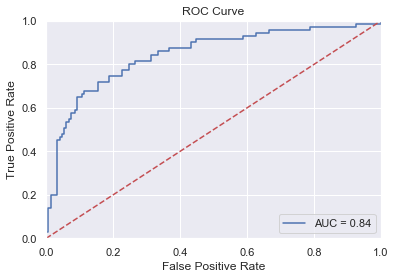

In [19]:
predictions = gs_rf.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_rf, 'val')
savefig('../images/rf/reg_val.png')

Balanced_Accuracy: 0.7002279635258359
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        47
           1       0.81      0.46      0.59        28

   micro avg       0.76      0.76      0.76        75
   macro avg       0.78      0.70      0.71        75
weighted avg       0.77      0.76      0.74        75



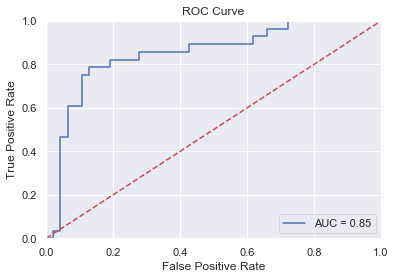

In [20]:
predictions = gs_rf.predict(features_test)
getReport(predictions, 'test')
plotROC(gs_rf, 'test')
savefig('../images/rf/reg_test.png')

### NN

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

nn = MLPClassifier(activation='logistic')

hidden_layer_sizes = [50, 75, 100, 125, 150]
solver = ['lbfgs']
alpha = [1e-3, 1e-4, 1e-5]
tol = [1e-3, 1e-4, 1e-5]



params_nn = {'hidden_layer_sizes': hidden_layer_sizes, 'solver': solver, 'tol': tol}
gs_nn = GridSearchCV(nn, params_nn, cv=10)

gs_nn.fit(features_train, target_train)

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'hidden_layer_sizes': [50, 75, 100, 125, 150], 'solver': ['lbfgs'], 'tol': [0.001, 0.0001, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Balanced_Accuracy: 0.686150234741784
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       150
           1       0.55      0.61      0.58        71

   micro avg       0.71      0.71      0.71       221
   macro avg       0.68      0.69      0.68       221
weighted avg       0.72      0.71      0.72       221



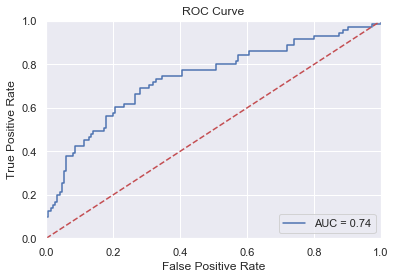

In [22]:
predictions = gs_nn.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_nn, 'val')
savefig('../images/nn/reg_val.png')

Balanced_Accuracy: 0.7682370820668694
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        47
           1       0.78      0.64      0.71        28

   micro avg       0.80      0.80      0.80        75
   macro avg       0.80      0.77      0.78        75
weighted avg       0.80      0.80      0.80        75



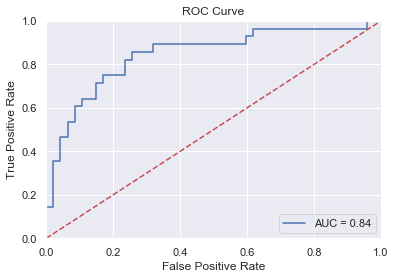

In [23]:
predictions = gs_nn.predict(features_test)
getReport(predictions, 'test')
plotROC(gs_nn, 'test')
savefig('../images/nn/reg_test.png')

### SVC

In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


svm = SVC(kernel = 'linear', probability=True)

costs = [0.001, 0.01, 0.1, 1, 5, 10, 100]
gammas = [0.005,.015, 0.01,0.02,0.03,0.04,0.05]
params_svm = {'C': costs, 'gamma' : gammas}

gs_svm = GridSearchCV(svm, params_svm, cv=10)

gs_svm.fit(features_train, target_train)

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10, 100], 'gamma': [0.005, 0.015, 0.01, 0.02, 0.03, 0.04, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Balanced_Accuracy: 0.6794366197183098
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       150
           1       0.65      0.48      0.55        71

   micro avg       0.75      0.75      0.75       221
   macro avg       0.72      0.68      0.69       221
weighted avg       0.74      0.75      0.74       221



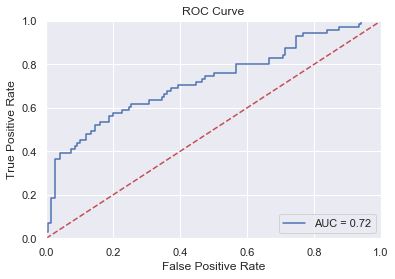

In [25]:
predictions = gs_svm.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_svm, 'val')
savefig('../images/svc/reg_val.png')

Balanced_Accuracy: 0.7610182370820668
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        47
           1       0.81      0.61      0.69        28

   micro avg       0.80      0.80      0.80        75
   macro avg       0.80      0.76      0.77        75
weighted avg       0.80      0.80      0.79        75



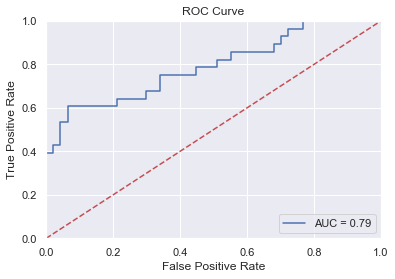

In [26]:
predictions = gs_svm.predict(features_test)
getReport(predictions, 'test')
plotROC(gs_svm, 'test')
savefig('../images/svc/reg_test.png')

### QDA REMOVE COLLINEAR VARIABLES

In [27]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()

tols = [1e-3, 1e-4, 1e-5]
params_qda = {'tol': tols}

gs_qda = GridSearchCV(qda, params_qda, cv=10)

gs_qda.fit(features_train, target_train)
predictions = gs_qda.predict(features_test)

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.

/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hhuang85/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.

Balanced_Accuracy: 0.6126760563380281
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       150
           1       1.00      0.23      0.37        71

   micro avg       0.75      0.75      0.75       221
   macro avg       0.87      0.61      0.61       221
weighted avg       0.82      0.75      0.69       221



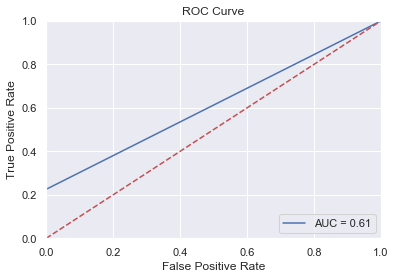

In [28]:
predictions = gs_qda.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_qda, 'val')
savefig('../images/qda/reg_val.png')

Balanced_Accuracy: 0.5892857142857143
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        47
           1       1.00      0.18      0.30        28

   micro avg       0.69      0.69      0.69        75
   macro avg       0.84      0.59      0.55        75
weighted avg       0.79      0.69      0.62        75



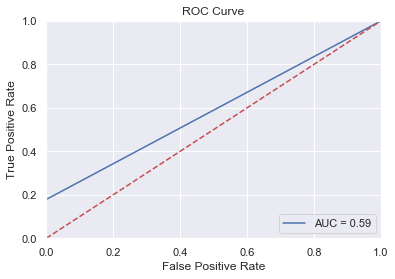

In [29]:
predictions = gs_qda.predict(features_test)
getReport(predictions, 'test')
plotROC(gs_qda, 'test')
savefig('../images/qda/reg_test.png')